In [1]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from typing import List, Optional
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from typing import Dict, Tuple

from package.processtransformer import constants
from package.processtransformer.models import transformer
from package.processtransformer.data.loader import LogsDataLoader
from package.processtransformer.data.processor import LogsDataProcessor
from package.processtransformer.constants import Task, Feature_Type


# Initialize data dir, if not exists
if not os.path.exists("datasets"): 
    os.mkdir("datasets")

# Task: Next Activity

In [2]:
class pipeline:
    
    def __init__(self, dataset_name: str, filepath: str, columns: List[str], additional_columns: Optional[Dict[Feature_Type, List[str]]],
                 datetime_format: str, task: Task, model_learning_rate: float, model_epochs: int, model_num_layers: int,
                 input_columns: List[str], target_columns: List[str] ):
        self.dataset_name: str = dataset_name
        self.filepath: str = filepath
        self.columns: List[str] = columns
        self.additional_columns: Optional[Dict[Feature_Type, List[str]]] = additional_columns
        self.datetime_format: str = datetime_format
        self.task: Task = task
        self.model_learning_rate: float = model_learning_rate
        self.model_epochs: int = model_epochs
        self.model_num_layers: int = model_num_layers
        
        self.target_columns: List[str] = target_columns
        for idx, target_col in enumerate(target_columns):
            if target_col == columns[1]:
                self.target_columns[idx] = "concept_name"
                break
                
        self.input_columns: List[str] = input_columns
        for idx, input_col in enumerate(input_columns):
            if input_col == columns[1]:
                self.input_columns[idx] = "concept_name"
                break
        
        # self._model_id: str = (
        #     f"{dataset_name}"
        #     f"##{'#'.join(self.columns)}"
        #     f"##{'#'.join(self.additional_columns)}"
        #     f"##{'#'.join(self.task.value)}"
        #     f"##{self.model_learning_rate}"
        #     f"##{self.model_epochs}"
        #     f"##{self.model_num_layers}")
        
        
    def __str__(self):
        return (
            f"dataset_name: '{self.dataset_name}'\n"
            f"filepath: '{self.filepath}'\n"
            f"columns: '{self.columns}'\n"
            f"additional_columns: '{self.additional_columns}'\n"
            f"datetime_format: '{self.datetime_format}'\n"
            f"task: '{self.task.value}'\n"
            f"Model learning rate: '{self.model_learning_rate}'\n"
            f"Model Epochs: '{self.model_epochs}'\n"
            f"Number of Transformer Layers in Model: '{self.model_num_layers}'\n"
            f"Target columns: '{self.target_columns}'\n"
            f"Input columns: '{self.input_columns}'\n")
        
    
    # preprocess the event log and save the train-test split as csv files
    def preprocess_log(self) -> List[int]:
        data_processor = LogsDataProcessor(
            name=self.dataset_name,
            filepath=self.filepath,
            columns=self.columns,
            additional_columns=self.additional_columns,  # Add all additional columns here, first all categorical, then all numerical features
            datetime_format=self.datetime_format,
            pool=4
        )
        # Preprocess the event log and make train-test split
        data_processor.process_logs(task=self.task, sort_temporally=False)
        
        # TODO: Compute the number of unique classes in each categorical column
        # train_df = pd.read_csv(os.path.join("datasets", self.dataset_name, "processed", f"{self._preprocessing_id}_train.csv"))
        # num_classes_list = data_processor._compute_num_classes(train_df)
        
        # return num_classes_list
    
    
    # load the preprocessed train-test split from the csv files
    def load_data(self) -> Tuple [ LogsDataLoader, Dict[str, pd.DataFrame], Dict[str, pd.DataFrame], Dict[str, Dict[str, int]], Dict[Feature_Type, List[str]] ]:
        data_loader = LogsDataLoader(name=self.dataset_name, input_columns=self.input_columns, target_columns=self.target_columns)
        train_dfs, test_dfs, word_dicts, feature_type_dict = data_loader.load_data()
        # num_output = len(y_word_dict[self.target_column])
        num_output = 0
        return data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict
    
    
    def prepare_data( self, data_loader, dfs: Dict[str, pd.DataFrame] ) -> Tuple[ Dict[str, NDArray[np.float32]], Dict[str, NDArray[np.float32]], int ]:
        print("Preparing data for task next_categorical...")
        # Prepare training examples for next categorical prediction task
        # train_token_x, train_token_y, train_additional_features, num_categorical_features, num_numerical_features = data_loader.prepare_data_next_categorical(
        #     train_df, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
        # )
        for idx, df in enumerate(dfs.values()):
            if idx == 0:
                token_dict_x, token_dict_y, max_case_length = data_loader.prepare_data(df=df, max_case_length=True)
            else:
                x_tokens, y_tokens = data_loader.prepare_data(df=df)
                token_dict_x.update(x_tokens)
                token_dict_y.update(y_tokens)
        return token_dict_x, token_dict_y, max_case_length
    
    
    # Prepare data and train the model
    def train(self,
            feature_type_dict: Dict[Feature_Type, List[str]],
            train_token_dict_x: Dict[str, NDArray[np.float32]],
            train_token_dict_y: Dict[str, NDArray[np.float32]],
            word_dicts: Dict[str, Dict[str, int]],
            max_case_length: int
            ) -> tf.keras.Model:
        
        batch_size = 12
    
        # Define and compile the model
        model = transformer.get_model(
            input_columns=self.input_columns,
            target_columns=self.target_columns,
            word_dicts=word_dicts,
            max_case_length=max_case_length,
            feature_type_dict=feature_type_dict
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(self.model_learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )
            
        # Train the model
        history = model.fit({f"input_{key}": value for key, value in train_token_dict_x.items() if key in self.input_columns},
                            {f"output_{key}": value for key, value in train_token_dict_y.items() if key in self.target_columns},
                            epochs=self.model_epochs, batch_size=batch_size)
            
        # Plot training loss
        self._plot_training_loss(history)
        return model
            
            
    # helper function for plotting the training loss
    def _plot_training_loss(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def evaluate(self, model, data_loader: LogsDataLoader, test_dfs: Dict[str, pd.DataFrame], max_case_length: int):
        print("Evaluating...")
        
        # Prepare lists to store evaluation metrics
        k, accuracies, fscores, precisions, recalls, weights = {}, {}, {}, {}, {}, {}
        for target_col in self.target_columns:
            k.update({target_col: []})
            accuracies.update({target_col: []})
            fscores.update({target_col: []})
            precisions.update({target_col: []})
            recalls.update({target_col: []})
            weights.update({target_col: []})

        # Calculate total number of samples
        # total_samples = len(test_df)
        total_samples = len( list(test_dfs.values())[0] )

        # Iterate over all prefixes (k)
        for i in range(1, max_case_length+1):
            print( "Prefix length: " + str(i) )
            test_data_subsets = {}
            for key, df in test_dfs.items():
                filtered_df = df[df["Prefix Length"] == i]
                test_data_subsets.update({key: filtered_df})
                
            # test_data_subset = test_df[test_df["concept_name_prefix-length"] == i]
            
            # if len(test_data_subset) > 0:
            if len( test_data_subsets[self.input_columns[0]] ) > 0:
                # Calculate weight for this prefix
                # weight = len(test_data_subset) / total_samples
                
                # Prepare the test data
                # test_token_x, test_token_y, test_additional_features, _, _ = data_loader.prepare_data_next_categorical(
                #     test_data_subset, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
                # )
                # Prepare the test data
                # x_token_dict, y_token_dict = data_loader.prepare_data(test_data_subset)
                
                # Prepare the test data
                for idx, test_data_subset in enumerate(test_data_subsets.values()):
                    if idx == 0:
                        x_token_dict, y_token_dict = data_loader.prepare_data(df=test_data_subset)
                    else:
                        x_tokens, y_tokens = data_loader.prepare_data(df=test_data_subset)
                        x_token_dict.update(x_tokens)
                        y_token_dict.update(y_tokens)
                
                
                # Filter x_token_dict and y_token_dict for input and target columns
                x_token_dict = {f"input_{key}": value for key, value in x_token_dict.items() if key in self.input_columns}
                y_token_dict = {f"output_{key}": value for key, value in y_token_dict.items() if key in self.target_columns}
                
                # Make predictions
                if len(self.target_columns) > 1:
                    result_dict = dict(zip( self.target_columns, [np.argmax(pred, axis=1) for pred in model.predict(x_token_dict)] ))
                else:
                    result_dict = dict(zip( self.target_columns, [np.argmax(model.predict(x_token_dict), axis=1)] ))
                # y_pred = np.argmax(model.predict(x_token_dict), axis=1)
                
                # Compute metrics
                for feature, result in result_dict.items():
                    accuracy = metrics.accuracy_score(y_token_dict[f"output_{feature}"], result)
                    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_token_dict[f"output_{feature}"],
                                                                                           result, average="weighted", zero_division=0)
                    weight = len(test_data_subsets[feature]) / total_samples
                    
                    k[feature].append(i)
                    accuracies[feature].append(accuracy)
                    fscores[feature].append(fscore)
                    precisions[feature].append(precision)
                    recalls[feature].append(recall)
                    weights[feature].append(weight)
                    
                # accuracy = metrics.accuracy_score(y_token_dict[self.target_column], y_pred)
                # precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_token_dict[self.target_column], y_pred, average="weighted", zero_division=0)
                # Store metrics and weight
                # k.append(i)
                # accuracies.append(accuracy)
                # fscores.append(fscore)
                # precisions.append(precision)
                # recalls.append(recall)
                # weights.append(weight)

        for target_col in self.target_columns:
            # Compute weighted mean metrics over all k
            weighted_accuracy = np.average(accuracies[target_col], weights=weights[target_col])
            weighted_fscore = np.average(fscores[target_col], weights=weights[target_col])
            weighted_precision = np.average(precisions[target_col], weights=weights[target_col])
            weighted_recall = np.average(recalls[target_col], weights=weights[target_col])
            # Append weighted mean metrics to the lists
            weights[target_col].append("")
            k[target_col].append("Weighted Mean")
            accuracies[target_col].append(weighted_accuracy)
            fscores[target_col].append(weighted_fscore)
            precisions[target_col].append(weighted_precision)
            recalls[target_col].append(weighted_recall)
            # Create a DataFrame to display the results
            print(f"Results for {target_col}")
            results_df = pd.DataFrame({
                'k': k[target_col],
                'weight': weights[target_col],
                'accuracy': accuracies[target_col],
                'fscore': fscores[target_col],
                'precision': precisions[target_col],
                'recall': recalls[target_col]
            })
            # Display the results
            print(results_df)
            
            
            
        # weighted_accuracy = np.average(accuracies, weights=weights)
        # weighted_fscore = np.average(fscores, weights=weights)
        # weighted_precision = np.average(precisions, weights=weights)
        # weighted_recall = np.average(recalls, weights=weights)

        # Append weighted mean metrics to the lists
        # weights.append("")
        # k.append("Weighted Mean")
        # accuracies.append(weighted_accuracy)
        # fscores.append(weighted_fscore)
        # precisions.append(weighted_precision)
        # recalls.append(weighted_recall)

        # # Create a DataFrame to display the results
        # results_df = pd.DataFrame({
        #     'k': k,
        #     'weight': weights,
        #     'accuracy': accuracies,
        #     'fscore': fscores,
        #     'precision': precisions,
        #     'recall': recalls
        # })

        # # Display the results
        # print(results_df)

In [3]:
### Helper Functions ###

# helper function: do only preprocessing on data
def preprocess(additional_columns, input_columns, target_columns):
    # initialize pipeline with parameters
    pipe = pipeline(
        dataset_name = "helpdesk",
        filepath = "helpdesk.csv",
        columns = ["Case ID", "Activity", "Complete Timestamp"],
        additional_columns = additional_columns,
        datetime_format = "%Y-%m-%d %H:%M:%S.%f",
        task = constants.Task.NEXT_CATEGORICAL,
        model_learning_rate = 0.001,
        model_epochs = 1,
        model_num_layers = 1,
        target_columns=target_columns,
        input_columns=input_columns)  # Examples: "concept_name", "Resource"
    # preprocess data
    pipe.preprocess_log()


# helper function
def run(additional_columns, input_columns, target_columns):
    # initialize pipeline with parameters
    pipe = pipeline(
        dataset_name = "helpdesk",
        filepath = "helpdesk.csv",
        columns = ["Case ID", "Activity", "Complete Timestamp"],
        additional_columns = additional_columns,
        datetime_format = "%Y-%m-%d %H:%M:%S.%f",
        task = constants.Task.NEXT_CATEGORICAL,
        model_learning_rate = 0.001,
        model_epochs = 10,
        model_num_layers = 2,
        target_columns=target_columns,
        input_columns=input_columns)  # Examples: "concept:name", "Resource"

    # print parameters
    print(pipe)

    # preprocess data
    pipe.preprocess_log()

    # load data
    data_loader, train_df, test_df, word_dicts, feature_type_dict = pipe.load_data()

    # prepare data
    train_token_dict_x, train_token_dict_y, max_case_length = pipe.prepare_data(data_loader, train_df)

    # train the model
    model = pipe.train(
                feature_type_dict = feature_type_dict,
                train_token_dict_x = train_token_dict_x,
                train_token_dict_y = train_token_dict_y,
                word_dicts = word_dicts,
                max_case_length = max_case_length
                )

    # evaluate the model
    pipe.evaluate(model, data_loader, test_df, max_case_length)
    print("")
    print("======================================")
    print("======================================")
    
    
# function for testing out code
def test(additional_columns, input_columns, target_columns):
    # initialize pipeline with parameters
    pipe = pipeline(
        dataset_name = "helpdesk",
        filepath = "helpdesk.csv",
        columns = ["Case ID", "Activity", "Complete Timestamp"],
        additional_columns = additional_columns,
        datetime_format = "%Y-%m-%d %H:%M:%S.%f",
        task = constants.Task.NEXT_CATEGORICAL,
        model_learning_rate = 0.001,
        model_epochs = 1,
        model_num_layers = 1,
        target_columns=target_columns,
        input_columns=input_columns)  # Examples: "concept:name", "Resource"
    
    # print parameters
    print(pipe)
    
    # load data
    data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict = pipe.load_data()
    
    # prepare data
    train_token_dict_x, train_token_dict_y, max_case_length = pipe.prepare_data(data_loader, train_dfs)
    
    # train the model
    model = pipe.train(
                feature_type_dict = feature_type_dict,
                train_token_dict_x = train_token_dict_x,
                train_token_dict_y = train_token_dict_y,
                word_dicts = word_dicts,
                max_case_length = max_case_length
                )


dataset_name: 'helpdesk'
filepath: 'helpdesk.csv'
columns: '['Case ID', 'Activity', 'Complete Timestamp']'
additional_columns: '{<Feature_Type.CATEGORICAL: 'categorical'>: ['Resource']}'
datetime_format: '%Y-%m-%d %H:%M:%S.%f'
task: 'next_categorical'
Model learning rate: '0.001'
Model Epochs: '1'
Number of Transformer Layers in Model: '1'
Target columns: '['Resource']'
Input columns: '['concept_name']'

All processed files for current spec found. Preprocessing skipped.
Loading data from preprocessed train-test split...
['concept_name', 'Resource']
Preparing data for task next_categorical...
Creating model for task next_categorical...
1121/1121 [==============================] - 54s 39ms/step - loss: 2.0366 - sparse_categorical_accuracy: 0.4025


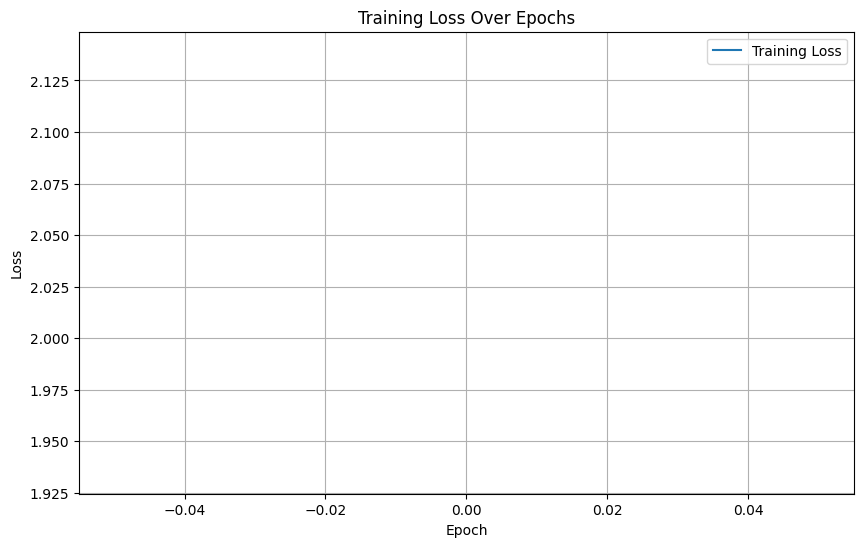

Evaluating...
Prefix length: 1
29/29 [==============================] - 3s 23ms/step
Prefix length: 2
29/29 [==============================] - 1s 25ms/step
Prefix length: 3
28/28 [==============================] - 1s 23ms/step
Prefix length: 4
12/12 [==============================] - 0s 24ms/step
Prefix length: 5
5/5 [==============================] - 0s 22ms/step
Prefix length: 6
3/3 [==============================] - 0s 19ms/step
Prefix length: 7
2/2 [==============================] - 0s 17ms/step
Prefix length: 8
1/1 [==============================] - 0s 106ms/step
Prefix length: 9
1/1 [==============================] - 0s 119ms/step
Prefix length: 10
1/1 [==============================] - 0s 109ms/step
Prefix length: 11
1/1 [==============================] - 0s 114ms/step
Prefix length: 12
1/1 [==============================] - 0s 107ms/step
Prefix length: 13
Prefix length: 14
Results for Resource
                k    weight  accuracy    fscore  precision    recall
0               

In [4]:
run(additional_columns={Feature_Type.CATEGORICAL: ["Resource"]}, input_columns=["Activity", "Resource"], target_columns=["Activity"])

In [ ]:
run(additional_columns={Feature_Type.CATEGORICAL: ["Resource"]}, input_columns=["Activity", "Resource"], target_columns=["Resource"])

In [ ]:
run(additional_columns={Feature_Type.CATEGORICAL: ["Resource"]}, input_columns=["Activity", "Resource"], target_columns=["Activity", "Resource"])

## Preprocessing and Loading

### Helpdesk

In [ ]:
# Process and load data for the next activity task
dataset_name = "helpdesk"
data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output, num_classes_list = process_and_load_data(
    dataset_name = dataset_name,
    filepath = "helpdesk.csv",
    columns = ["Case ID", "Activity", "Complete Timestamp"],
    additional_columns = ["Resource"],
    datetime_format = "%Y-%m-%d %H:%M:%S.%f",
    task = constants.Task.NEXT_ACTIVITY)

### Sepsis

In [ ]:
# Dataset processing
dataset_name = "sepsis"
data_processor = LogsDataProcessor(
    name=dataset_name,
    filepath="sepsis.xes",
    columns=["case:concept:name", "concept:name", "time:timestamp"],  # specify the columns name containing case_id, activity name and timestamp
    additional_columns=["org:group"],
    datetime_format="%Y-%m-%d %H:%M:%S%z",
    pool=4
)
data_processor.process_logs(task=constants.Task.NEXT_ACTIVITY, sort_temporally=False)

# Garbage collection
del data_processor

## Data Preparation for Training

In [ ]:
# Prepare training examples for next activity prediction task
train_token_x, train_token_y, train_additional_features, num_categorical_features, num_numerical_features = data_loader.prepare_data_next_activity(
    train_df, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
)

# Garbage collection
del data_loader

## Model Training

In [ ]:
# Model parameters
learning_rate = 0.001
batch_size = 12
epochs = 3

# Define and compile the model
model = transformer.get_next_activity_model(
    max_case_length=max_case_length,
    vocab_size=vocab_size,
    output_dim=num_output,
    num_categorical_features=num_categorical_features,
    num_numerical_features=num_numerical_features,
    num_classes_list=num_classes_list,  # Pass the computed number of classes list
    num_layers=1
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model
if train_additional_features.shape[1] == 0:
    model.fit([train_token_x], train_token_y, epochs=epochs, batch_size=batch_size)
else:
    model.fit([train_token_x, train_additional_features], train_token_y, epochs=epochs, batch_size=batch_size)

## Evaluation

In [ ]:
# Prepare lists to store evaluation metrics
k, accuracies, fscores, precisions, recalls, weights = [], [], [], [], [], []

# Calculate total number of samples
total_samples = len(test_df)

# Iterate over all prefixes (k)
for i in range(max_case_length):
    test_data_subset = test_df[test_df["k"] == i]
    if len(test_data_subset) > 0:
        # Calculate weight for this prefix
        weight = len(test_data_subset) / total_samples
        
        # Prepare the test data
        test_token_x, test_token_y, test_additional_features, _, _ = data_loader.prepare_data_next_activity(
            test_data_subset, x_word_dict, y_word_dict, max_case_length, full_df=pd.concat([train_df, test_df])
        )
        
        # Make predictions
        if test_additional_features.shape[1] != 0:
            y_pred = np.argmax(model.predict([test_token_x, test_additional_features]), axis=1)
        else:
            y_pred = np.argmax(model.predict([test_token_x]), axis=1)
        
        # Compute metrics
        accuracy = metrics.accuracy_score(test_token_y, y_pred)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(test_token_y, y_pred, average="weighted")
        
        # Store metrics and weight
        k.append(i)
        accuracies.append(accuracy)
        fscores.append(fscore)
        precisions.append(precision)
        recalls.append(recall)
        weights.append(weight)

# Compute weighted mean metrics over all k
weighted_accuracy = np.average(accuracies, weights=weights)
weighted_fscore = np.average(fscores, weights=weights)
weighted_precision = np.average(precisions, weights=weights)
weighted_recall = np.average(recalls, weights=weights)

# Append weighted mean metrics to the lists
k.append(max_case_length)
accuracies.append(weighted_accuracy)
fscores.append(weighted_fscore)
precisions.append(weighted_precision)
recalls.append(weighted_recall)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'k': k,
    'accuracy': accuracies,
    'fscore': fscores,
    'precision': precisions,
    'recall': recalls
})

# Display the results
print(results_df)

In [ ]:
print('Average accuracy across all prefixes:', np.mean(accuracies))
print('Average f-score across all prefixes:', np.mean(fscores))
print('Average precision across all prefixes:', np.mean(precisions))
print('Average recall across all prefixes:', np.mean(recalls))

# Task: Next Time  -- Ignored for now

## Preprocessing and Loading

### Helpdesk

In [ ]:
# Process and load data for the next activity task
dataset_name = "helpdesk"
data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output, num_classes_list = process_and_load_data(
    dataset_name = dataset_name,
    filepath = "helpdesk.csv",
    columns = ["Case ID", "Activity", "Complete Timestamp"],
    additional_columns = ["Resource", "product"],
    datetime_format = "%Y-%m-%d %H:%M:%S.%f",
    task = constants.Task.NEXT_TIME)

### Sepsis

## Data Preparation for Training

In [ ]:
# Prepare training examples for next time prediction task
train_token_x, train_time_x, train_token_y, train_additional_features, time_scaler, y_scaler, num_categorical_features, num_numerical_features = data_loader.prepare_data_next_time(
    train_df, x_word_dict, max_case_length, shuffle=True)

# Garbage collection
del data_loader

# Task: Remaining Time -- Ignored for now

## Preprocessing and Loading

### Helpdesk

### Sepsis

In [ ]:
# Process and load data for the next time task
dataset_name = "sepsis"
data_loader, train_df, test_df, x_word_dict, y_word_dict, max_case_length, vocab_size, num_output, num_classes_list = process_and_load_data(
    dataset_name, "sepsis.xes", ["case:concept:name", "concept:name", "time:timestamp"], ["org:group"], "%Y-%m-%d %H:%M:%S%z", constants.Task.NEXT_TIME)

## Data Preparation for Training